## Imports and reading dataset


!pip install transformers torch

!pip install seqeval

!pip install git+https://www.github.com/keras-team/keras-contrib.git

!pip install googletrans==4.0.0-rc1
!pip install --upgrade googletrans==4.0.0-rc1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
nltk.download('punkt')
import torch
from transformers import AutoTokenizer, AutoModel
import pickle
from imblearn.over_sampling import SMOTE
# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
# keras
from keras.models import Sequential, load_model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("datasets/new_merged_df.csv")

# df = df.sort_values(by='emotion').reset_index(drop=True)

df

,text,emotion
0,da ana lma atkharrag,joy
1,baad el fetar hagelko,neutral
2,hahahahahha helw elkalam dah,happiness
3,kan 3ayz yroh yl3ab fe pyramids bayen,neutral
4,dah elly ana asdi aleih harfyan,neutral
...,...,...
2804,eh el araf da ana mt3sab,angry
2805,tab law omt w gbthalk..,neutral
2806,ana msh msda2 ana masdoom,surprise
2807,eh el mofg2at el 8areba de,surprise


In [3]:
df['emotion'].unique()

array(['joy', 'neutral', 'happiness', 'angry', 'sadness', 'surprise',
       'fear'], dtype=object)

In [4]:
rows_per_class = 100

result = df.groupby('emotion').head(rows_per_class)
df = result.copy()
df = df.reset_index(drop=True)

df

,text,emotion
0,da ana lma atkharrag,joy
1,baad el fetar hagelko,neutral
2,hahahahahha helw elkalam dah,happiness
3,kan 3ayz yroh yl3ab fe pyramids bayen,neutral
4,dah elly ana asdi aleih harfyan,neutral
...,...,...
647,mofag2a 7elwa awii,surprise
648,5ayef men el gaii,fear
649,ana 3omry ma koft zay enhrdh,fear
650,ana msh msda2 ana masdoom,surprise


joy: Count = 100 -----------------> Percentage = 15.34%
neutral: Count = 100 -----------------> Percentage = 15.34%
happiness: Count = 100 -----------------> Percentage = 15.34%
angry: Count = 100 -----------------> Percentage = 15.34%
sadness: Count = 100 -----------------> Percentage = 15.34%
surprise: Count = 91 -----------------> Percentage = 13.96%
fear: Count = 61 -----------------> Percentage = 9.36%
df shape : (652, 2)


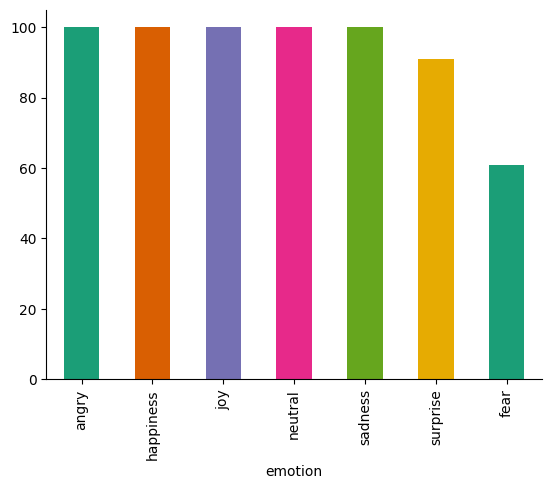

In [5]:
df.groupby('emotion').size().sort_values(ascending=False).plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

# Calculating and printing percentages in descending order
emotion_counts = df['emotion'].value_counts()
total_samples = len(df)

for emotion, count in emotion_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{emotion}: Count = {count} -----------------> Percentage = {percentage:.2f}%")
print("df shape :",f"{df.shape}")
    

## a) Step 1 : Preprocessing

<!-- + Remove URLs
+ Remove user mentions
+ Remove hashtags
+ Remove punctuation
+ Tokenize the text
+ Convert to lower case
+ Join the tokens back into a clean text -->

<!-- + Remove repeated letters -->




In [6]:
def clean_text(text):
    # Remove URLs https://www.example.com/
    text = re.sub(r'http\S+', '', text)

    # Remove user mentions @mohamed_samy
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)

    # Remove hashtags #free_palestine
    text = re.sub(r'#', '', text)

    # Remove punctuation period, comma, apostrophe, quotation, question, exclamation, brackets, braces, parenthesis, dash, hyphen, ellipsis, colon, semicolon
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove repeated letters
    # tokens = [re.sub(r'(.)\1+', r'\1', word) for word in tokens]

    # Convert to lower case
    tokens = [word.lower() for word in tokens]

    # Join the tokens back into a clean text
    clean_text = ' '.join(tokens)

    return clean_text

df['clean_text'] = df['text'].apply(clean_text)
df

,text,emotion,clean_text
0,da ana lma atkharrag,joy,da ana lma atkharrag
1,baad el fetar hagelko,neutral,baad el fetar hagelko
2,hahahahahha helw elkalam dah,happiness,hahahahahha helw elkalam dah
3,kan 3ayz yroh yl3ab fe pyramids bayen,neutral,kan 3ayz yroh yl3ab fe pyramids bayen
4,dah elly ana asdi aleih harfyan,neutral,dah elly ana asdi aleih harfyan
...,...,...,...
647,mofag2a 7elwa awii,surprise,mofag2a 7elwa awii
648,5ayef men el gaii,fear,5ayef men el gaii
649,ana 3omry ma koft zay enhrdh,fear,ana 3omry ma koft zay enhrdh
650,ana msh msda2 ana masdoom,surprise,ana msh msda2 ana masdoom


- Removing Duplicates again after cleaning

In [7]:
# df = df.drop_duplicates()
# df.shape

In [8]:
test_clean = clean_text("@Mo_Hussein eh elgamal da, alf mabrook!! #free_palestine https://www.example.com/")
test_clean

'eh elgamal da alf mabrook free_palestine'

### Translate clean_text to Arabic


https://github.com/ssut/py-googletrans/issues/257

In [9]:
from googletrans import Translator

def translate_to_arabic(text):
    translator = Translator()
    translation = translator.translate(text, dest='ar')
    return translation.text

In [10]:
df['arabic_text'] = df['clean_text'].apply(translate_to_arabic)
df

In [ ]:
test_statment = translate_to_arabic("eh elgamal da alf mabrook")
print(test_statment)

إيه الجمال دى ألف مبروك


In [ ]:
# Count the number of rows before removing non-Arabic text
original_rows = df.shape[0]
print(f'Original number of rows: {original_rows}')

# Remove rows with non-Arabic text in 'arabic_text' column
df = df[df['arabic_text'].apply(lambda x: all(ord(char) < 128 for char in x))]

# Count the number of rows after removing non-Arabic text
remaining_rows = df.shape[0]
print(f'Remaining number of rows after removing non-Arabic text: {remaining_rows}')

# Print or return the updated DataFrame
print(df)

Original number of rows: 652
Remaining number of rows after removing non-Arabic text: 5
                 text   emotion        clean_text       arabic_text
266  bey2oulo magatsh   neutral  bey2oulo magatsh  bey2oulo magatsh
320  kalemtek yabenti   neutral  kalemtek yabenti   kaletek yabenti
542         bethazari  surprise         bethazari         bethazari
642           mofag2a  surprise           mofag2a           mofag2a
645          mofag2a!  surprise           mofag2a           mofag2a


## b) Step 2: The usage of Word Embedding
<!-- + AraBERT -->


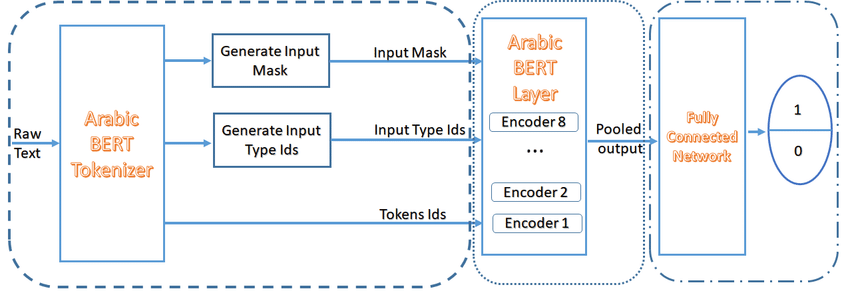

https://huggingface.co/asafaya/bert-base-arabic

- Load the pre-trained AraBERT tokenizer and model

In [ ]:
AraBERT_tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
AraBERT_model = AutoModel.from_pretrained("asafaya/bert-base-arabic")

In [ ]:
def get_embeddings(text):
    tokens = AraBERT_tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = AraBERT_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

In [ ]:
df['arabert_embeddings'] = df['arabic_text'].apply(get_embeddings)
df

C:\Users\husse\AppData\Local\Temp\ipykernel_6196\3845998709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arabert_embeddings'] = df['arabic_text'].apply(get_embeddings)


,text,emotion,clean_text,arabic_text,arabert_embeddings
266,bey2oulo magatsh,neutral,bey2oulo magatsh,bey2oulo magatsh,"[-0.5157073, -0.42321014, -0.3278152, -0.42293..."
320,kalemtek yabenti,neutral,kalemtek yabenti,kaletek yabenti,"[-0.37698284, -0.18619601, -0.20631357, -0.660..."
542,bethazari,surprise,bethazari,bethazari,"[0.0024090677, -0.78212804, -0.190863, 0.06980..."
642,mofag2a,surprise,mofag2a,mofag2a,"[0.022896843, -0.93940455, -0.19115643, -0.446..."
645,mofag2a!,surprise,mofag2a,mofag2a,"[0.022896843, -0.93940455, -0.19115643, -0.446..."


- Finds similar texts within the dataset based on the embeddings haved generated using AraBERT

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity

# word_embeddings = df.set_index('arabic_text')['arabert_embeddings']

# # Function to find similar words
# def find_similar_words(target_text, embeddings):
#     target_embedding = np.array(embeddings.loc[target_text]).reshape(1, -1)
#     similarities = {}

#     for text, embedding in embeddings.items():
#         if text != target_text:
#             embedding = np.array(embedding).reshape(1, -1)
#             similarity = cosine_similarity(target_embedding, embedding)[0][0]
#             similarities[text] = similarity

#     # Sort texts by similarity in descending order
#     similar_texts = sorted(similarities, key=similarities.get, reverse=True)

#     return similar_texts

In [ ]:
# # Example usage:
# target_text = 'كفاية زان'  # Replace with the text you're interested in
# similar_texts = find_similar_words(target_text, word_embeddings)

# # Print the top similar texts
# print(f"Texts similar to '{target_text}':")
# for i, text in enumerate(similar_texts[:20], 1):
#     print(f"{i}) {text}")

- Save the dataset after embedding 

In [ ]:
# after_embedding_df = df.copy()
# after_embedding_df.to_csv('after_embedding_df.csv', index=False)

## c) Step 3: Models Development
<!-- + Split data into 80% train and 20% test
+ Bi-LSTM model devalopment
+ CNN model devalopment -->

<!-- https://en.wikipedia.org/wiki/Conditional_random_field#:~:text=Conditional%20random%20fields%20(CRFs)%20are,can%20take%20context%20into%20account. -->

In [ ]:
X = df['arabert_embeddings'].astype(str).tolist()
y = df['emotion']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(X_sequences)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data only
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [ ]:
# Bi-LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
model_lstm.add(Bidirectional(LSTM(64,return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(32)))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(7, activation='softmax'))
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

print(f"LSTM Model Accuracy: {accuracy_lstm * 100:.2f}%")



Epoch 1/10


1/1 [==============================] - 9s 9s/step - loss: 1.9413 - accuracy: 0.3333 - val_loss: 1.9197 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.9195 - accuracy: 0.6667 - val_loss: 1.8892 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 1.8939 - accuracy: 0.6667 - val_loss: 1.8518 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 1.8636 - accuracy: 0.6667 - val_loss: 1.8058 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 1.8270 - accuracy: 0.6667 - val_loss: 1.7489 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 1.7816 - accuracy: 0.6667 - val_loss: 1.6766 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 1.7246 - accuracy: 0.6667 - val_loss: 1.5841 - val_accuracy: 1.0000
Epoch 8/10
1/1 [=====================

In [ ]:
class_names = label_encoder.classes_
y_test_names = label_encoder.inverse_transform(y_test)
y_pred_names = label_encoder.inverse_transform(y_pred_lstm)

report = classification_report(y_test_names, y_pred_names, target_names=class_names)
print("LSTM Model Classification Report:\n", report)

LSTM Model Classification Report:
               precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       1.0
    surprise       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

- Saving Bi-LSTM model

In [ ]:
# Saving the Bi-LSTM model
# model_lstm.save("Bi-LSTM_model.h5")

In [ ]:
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# CNN
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
# model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(7, activation='softmax'))
# Add CRF layer----------------------------------
# model_cnn.add(CRF(7))
# model_cnn.compile(optimizer='adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])
# -----------------------------------------------
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
y_pred_cnn = np.argmax(model_cnn.predict(X_test), axis=1)
accuracy_cnn = accuracy_score(y_test, y_pred_cnn) 
print(f"CNN Model Accuracy: {accuracy_cnn * 100:.2f}%")

Epoch 1/10
1/1 [==============================] - 1s 877ms/step - loss: 1.9500 - accuracy: 0.0000e+00 - val_loss: 1.8106 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 47ms/step - loss: 1.8379 - accuracy: 0.6667 - val_loss: 1.7003 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 47ms/step - loss: 1.7505 - accuracy: 0.6667 - val_loss: 1.5953 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 47ms/step - loss: 1.6689 - accuracy: 0.6667 - val_loss: 1.4950 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 47ms/step - loss: 1.5922 - accuracy: 0.6667 - val_loss: 1.4029 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 56ms/step - loss: 1.5177 - accuracy: 0.6667 - val_loss: 1.3115 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 33ms/step - loss: 1.4416 - accuracy: 0.6667 - val_loss: 1.2185 - val_accuracy: 1.0000
Epoch 8/10
1/1 [======

In [ ]:
class_names = label_encoder.classes_
y_test_names = label_encoder.inverse_transform(y_test)
y_pred_names = label_encoder.inverse_transform(y_pred_cnn)

report = classification_report(y_test_names, y_pred_names, target_names=class_names)
print("CNN Model Classification Report:\n", report)

CNN Model Classification Report:
               precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       1.0
    surprise       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

## Testing models
+ testing Bi-LSTM
+ testing CNN

In [ ]:
def preprocess_text_for_prediction(text, tokenizer, max_length):
    cleaned_text = clean_text(text)
    translated_text = translate_to_arabic(cleaned_text)
    # Tokenize and pad the text
    text_sequence = tokenizer.texts_to_sequences([translated_text])
    text_padded = pad_sequences(text_sequence, maxlen=max_length)
    return text_padded

def predict_emotion(model, text_padded):
    predictions = model.predict(text_padded)
    return predictions[0]  # Return the probabilities for each class

In [ ]:
new_text = "mtolosh eno himot dana awadeko f dahya"

new_text_padded = preprocess_text_for_prediction(new_text, tokenizer, X_padded.shape[1])
predicted_probabilities = predict_emotion(model_lstm, new_text_padded)

# Display the predicted emotion and probabilities
predicted_class = np.argmax(predicted_probabilities)
predicted_emotion = label_encoder.classes_[predicted_class]
probabilities_dict = {emotion: round(prob * 100, 2) for emotion, prob in zip(label_encoder.classes_, predicted_probabilities)}
sorted_probabilities = dict(sorted(probabilities_dict.items(), key=lambda item: item[1], reverse=True))

print(f"Predicted Emotion: {predicted_emotion}")
print("Probabilities:")
for emotion, prob in sorted_probabilities.items():
    print(f"{emotion}: {prob}%")

1/1 [==============================] - 0s 203ms/step
Predicted Emotion: surprise
Probabilities:
surprise: 26.0%
neutral: 16.92%


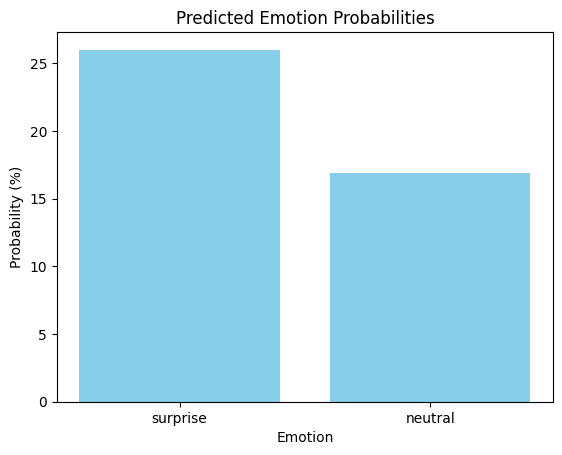

In [ ]:
# Plotting the probabilities
plt.bar(sorted_probabilities.keys(), sorted_probabilities.values(), color='skyblue')
plt.title('Predicted Emotion Probabilities')
plt.xlabel('Emotion')
plt.ylabel('Probability (%)')
plt.show()